<a href="https://colab.research.google.com/github/Charles980903/Proj2/blob/main/Another_copy_of_Untitled5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests

try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x, total, unit: x  # If tqdm doesn't exist, replace it with a function that does nothing
    print('**** Could not import tqdm. Please install tqdm for download progressbars! (pip install tqdm) ****')

# Python2 compatibility
try:
    input = raw_input
except NameError:
    pass

download_dict = {
    '1) Kuzushiji-MNIST (10 classes, 28x28, 70k examples)': {
        '1) MNIST data format (ubyte.gz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-images-idx3-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-labels-idx1-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-images-idx3-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-labels-idx1-ubyte.gz'],
        '2) NumPy data format (.npz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz'],
    },
    '2) Kuzushiji-49 (49 classes, 28x28, 270k examples)': {
        '1) NumPy data format (.npz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz'],
    },
    '3) Kuzushiji-Kanji (3832 classes, 64x64, 140k examples)': {
        '1) Folders of images (.tar)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kkanji/kkanji.tar'],
    }

}

# Download a list of files
def download_list(url_list):
    for url in url_list:
        path = url.split('/')[-1]
        r = requests.get(url, stream=True)
        with open(path, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            print('Downloading {} - {:.1f} MB'.format(path, (total_length / 1024000)))

            for chunk in tqdm(r.iter_content(chunk_size=1024), total=int(total_length / 1024) + 1, unit="KB"):
                if chunk:
                    f.write(chunk)
    print('All dataset files downloaded!')

# Ask the user about which path to take down the dict
def traverse_dict(d):
    print('Please select a download option:')
    keys = sorted(d.keys())  # Print download options
    for key in keys:
        print(key)

    userinput = input('> ').strip()

    try:
        selection = int(userinput) - 1
    except ValueError:
        print('Your selection was not valid')
        traverse_dict(d)  # Try again if input was not valid
        return

    selected = keys[selection]

    next_level = d[selected]
    if isinstance(next_level, list):  # If we've hit a list of downloads, download that list
        download_list(next_level)
    else:
        traverse_dict(next_level)     # Otherwise, repeat with the next level

traverse_dict(download_dict)

Please select a download option:
1) Kuzushiji-MNIST (10 classes, 28x28, 70k examples)
2) Kuzushiji-49 (49 classes, 28x28, 270k examples)
3) Kuzushiji-Kanji (3832 classes, 64x64, 140k examples)
> 1
Please select a download option:
1) MNIST data format (ubyte.gz)
2) NumPy data format (.npz)
> 2


100%|██████████| 17954/17954 [00:07<00:00, 2438.04KB/s]


100%|██████████| 30/30 [00:00<00:00, 409.27KB/s]


100%|██████████| 3008/3008 [00:01<00:00, 1556.50KB/s]


100%|██████████| 6/6 [00:00<00:00, 18822.61KB/s]

All dataset files downloaded!


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import os
import random
from tensorflow.keras.optimizers import Adam
import pandas as pd
import time

def set_seed(seed=42):
    """Ensure reproducibility by setting random seeds."""
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.config.experimental.enable_op_determinism()
set_seed(42)


def log_time(step_name, start_time):
    end_time = time.time()
    print(f"{step_name} completed in {end_time - start_time:.2f} seconds.")
    return end_time

In [ ]:
# Load the Kuzushiji-MNIST data
train_images = np.load('kmnist-train-imgs.npz')['arr_0']
train_labels = np.load('kmnist-train-labels.npz')['arr_0']
test_images = np.load('kmnist-test-imgs.npz')['arr_0']
test_labels = np.load('kmnist-test-labels.npz')['arr_0']

train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Flatten the images for input into the Stacked Autoencoder
train_images_flattened = train_images.reshape(-1, 784)
test_images_flattened = test_images.reshape(-1, 784)

x_test = test_images_flattened
y_test = test_labels

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(train_images_flattened, train_labels, test_size=0.2, random_state=42)

In [ ]:
def build_sae(bottleneck_size):
    # Encoder
    input_layer = Input(shape=(784,), name="input_layer")
    encoder = Dense(800, activation='relu', name="encoder_1")(input_layer)
    encoder = Dense(200, activation='relu', name="encoder_2")(encoder)
    bottleneck = Dense(bottleneck_size, activation='relu', name="bottleneck")(encoder)

    # Decoder
    decoder = Dense(200, activation='relu', name="decoder_1")(bottleneck)
    decoder = Dense(800, activation='relu', name="decoder_2")(decoder)
    output_layer = Dense(784, activation='sigmoid', name="output_layer")(decoder)

    # Build model
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    return autoencoder

In [ ]:

def extract_features(autoencoder, data):

    encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.layers[3].output)
    features = encoder_model.predict(data)
    return features

Training SAE with bottleneck size 32, batch size 64, patience 5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Bottleneck size 32, Batch size 64, Patience 5 - CV Accuracy: 0.9597
Training SAE with bottleneck size 32, batch size 64, patience 10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Bottleneck size 32, Batch size 64, Patience 10 - CV Accuracy: 0.9572
Training SAE with bottleneck size 32, batch size 128, patience 5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Bottleneck size 32, Batch size 128, Patience 5 - CV Accuracy: 0.9585
Training SAE with bottleneck size 32, batch size 128, patience 10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Bottleneck size 32, Batch size 128, Patience 10 - CV Accuracy: 0.9610
Training SAE with bottleneck size 64, batch size 64, patience 5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
375/375 ━━━━━━━━━━━━━

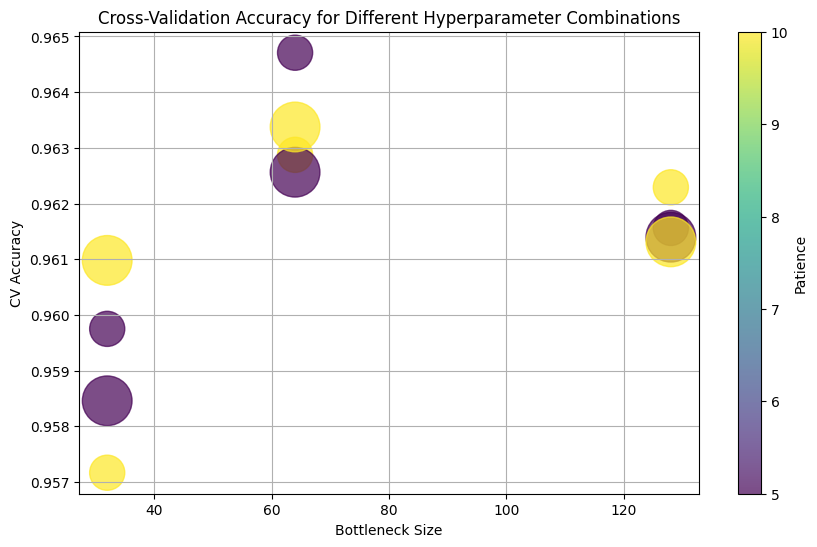

In [ ]:
from itertools import product



# Define ranges for hyperparameters to test
bottleneck_sizes = [32, 64, 128]
batch_sizes = [64, 128]
patience_values = [5, 10]


cv_results = {}



for bottleneck_size, batch_size, patience in product(bottleneck_sizes, batch_sizes, patience_values):
    print(f"Training SAE with bottleneck size {bottleneck_size}, batch size {batch_size}, patience {patience}")

    # Build the autoencoder
    autoencoder = build_sae(bottleneck_size)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Train the autoencoder with early stopping
    autoencoder.fit(
        x_train, x_train,
        epochs=50,  # Set a high epoch limit, early stopping will determine the actual stopping point
        batch_size=batch_size,
        validation_data=(x_val, x_val),
        callbacks=[early_stopping],
        verbose=0
    )

    # Extract features from the bottleneck layer
    train_features = extract_features(autoencoder, x_train)
    val_features = extract_features(autoencoder, x_val)

    # Scale the features for the SVM classifier
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)
    val_features_scaled = scaler.transform(val_features)

    # Train an SVM classifier using cross-validation
    svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
    scores = cross_val_score(svm_classifier, train_features_scaled, y_train, cv=5)
    avg_accuracy = np.mean(scores)

    # Store the results
    cv_results[(bottleneck_size, batch_size, patience)] = avg_accuracy
    print(f"Bottleneck size {bottleneck_size}, Batch size {batch_size}, Patience {patience} - CV Accuracy: {avg_accuracy:.4f}")


best_params = max(cv_results, key=cv_results.get)
best_accuracy = cv_results[best_params]
print(f"\nBest parameters: Bottleneck size = {best_params[0]}, Batch size = {best_params[1]}, Patience = {best_params[2]}")
print(f"Best CV Accuracy: {best_accuracy:.4f}")

# Plot the cross-validation results
bottleneck_sizes_plot, batch_sizes_plot, patience_plot, accuracies = zip(*[(k[0], k[1], k[2], v) for k, v in cv_results.items()])
plt.figure(figsize=(10, 6))
plt.scatter(bottleneck_sizes_plot, accuracies, c=patience_plot, cmap='viridis', s=[10 * b for b in batch_sizes_plot], alpha=0.7)
plt.colorbar(label='Patience')
plt.title('Cross-Validation Accuracy for Different Hyperparameter Combinations')
plt.xlabel('Bottleneck Size')
plt.ylabel('CV Accuracy')
plt.grid(True)
plt.show()


In [ ]:
from itertools import product
bottleneck_sizes = [48,52,56,60,64,68,72,74]



cv_results = {}



for bottleneck_size in bottleneck_sizes:
    print(f"Training SAE with bottleneck size {bottleneck_size}")

    # Build the autoencoder
    autoencoder = build_sae(bottleneck_size)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the autoencoder with early stopping
    autoencoder.fit(
        x_train, x_train,
        epochs=50,  # Set a high epoch limit, early stopping will determine the actual stopping point
        batch_size=64,
        validation_data=(x_val, x_val),
        callbacks=[early_stopping],
        verbose=0
    )

    # Extract features from the bottleneck layer
    train_features = extract_features(autoencoder, x_train)
    val_features = extract_features(autoencoder, x_val)

    # Scale the features for the SVM classifier
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)
    val_features_scaled = scaler.transform(val_features)

    # Train an SVM classifier using cross-validation
    svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
    scores = cross_val_score(svm_classifier, train_features_scaled, y_train, cv=5)
    avg_accuracy = np.mean(scores)

    # Store the results
    cv_results[(bottleneck_size)] = avg_accuracy
    print(f"Bottleneck size {bottleneck_size} - CV Accuracy: {avg_accuracy:.4f}")





Training SAE with bottleneck size 48
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Bottleneck size 48 - CV Accuracy: 0.9623
Training SAE with bottleneck size 52
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Bottleneck size 52 - CV Accuracy: 0.9620
Training SAE with bottleneck size 56
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Bottleneck size 56 - CV Accuracy: 0.9627
Training SAE with bottleneck size 60
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Bottleneck size 60 - CV Accuracy: 0.9640
Training SAE with bottleneck size 64
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Bottleneck size 64 - CV Accuracy: 0.9643
Training SAE with bottleneck size 68
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Bottleneck size 68 - CV Accuracy: 0.9641
Training SAE with bottleneck

TypeError: 'int' object is not subscriptable

In [ ]:
best_params = max(cv_results, key=cv_results.get)
best_accuracy = cv_results[best_params]
print(f"\nBest parameters: Bottleneck size = {best_params}")
print(f"Best CV Accuracy: {best_accuracy:.4f}")


Best parameters: Bottleneck size = 64
Best CV Accuracy: 0.9643


Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0766 - val_loss: 0.0326
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0298 - val_loss: 0.0251
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0237 - val_loss: 0.0224
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0209 - val_loss: 0.0205
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0192 - val_loss: 0.0192
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0183 - val_loss: 0.0189
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0177 - val_loss: 0.0185
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0172 - val_loss: 0.0182
Epoch 9/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0168 - val_loss: 0.0182
Epoch 10/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0166 - val_loss: 0.0179
Epoch 11/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0164 - val_loss: 0.0180
Epoch 12/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

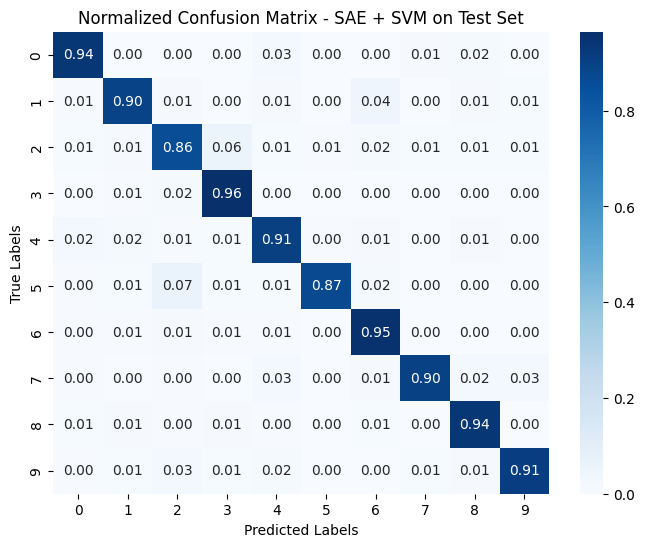

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    """Plot a normalized confusion matrix."""
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

time_train_saesvm = time.time()

# Build and compile the autoencoder
autoencoder = build_sae(64)
autoencoder.compile(optimizer='adam', loss='mse')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train on the entire training set
autoencoder.fit(
    x_train, x_train,
    epochs=50,
    batch_size=64,
    validation_data=(x_val, x_val),
    callbacks=[early_stopping],
    verbose=1
)

# Step 2: Extract Bottleneck Features
train_features = extract_features(autoencoder, x_train)
test_features = extract_features(autoencoder, x_test)

# Step 3: Scale the Features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Step 4: Train the SVM Classifier on the Extracted Features
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_classifier.fit(train_features_scaled, y_train)

# Step 5: Evaluate on the Test Set
test_predictions = svm_classifier.predict(test_features_scaled)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"\nSAE + SVM Test Accuracy: {test_accuracy:.4f}")
log_time("Train SAE+SVM time", time_train_saesvm)

# Step 6: Confusion Matrix and Classification Report
cm = confusion_matrix(y_test, test_predictions, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
plt.title("Normalized Confusion Matrix - SAE + SVM on Test Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
sae_total_params = autoencoder.count_params()
print(f"Total parameters in SAE model: {sae_total_params}")

Total parameters in SAE model: 1602848


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


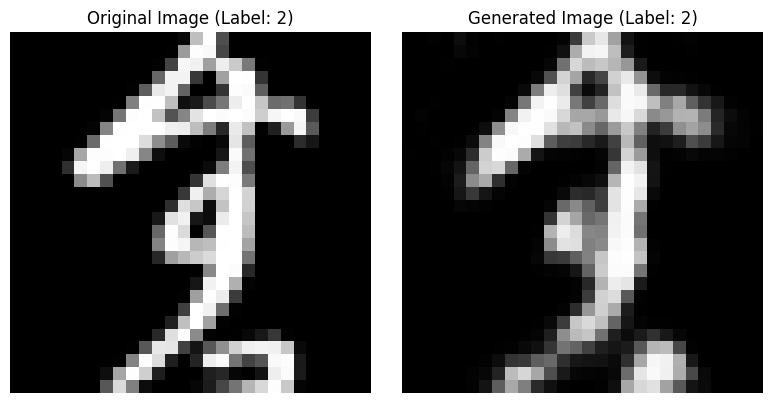

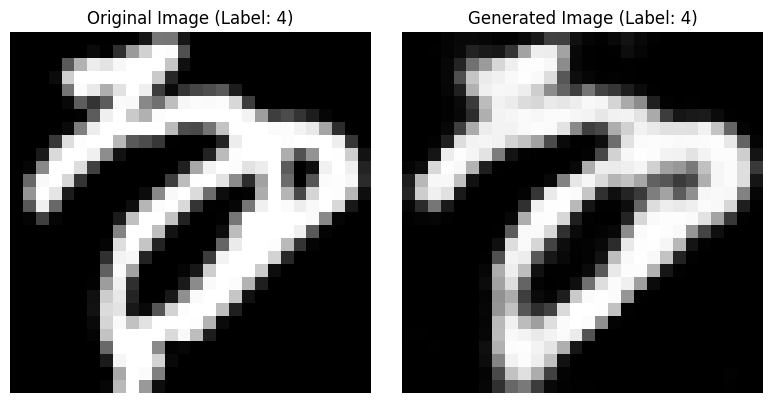

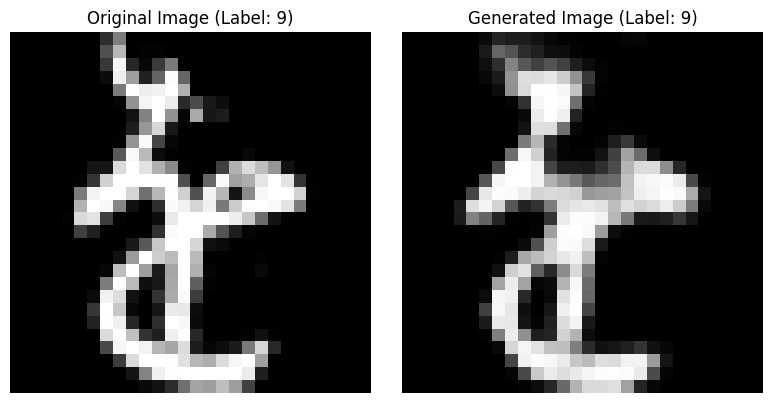

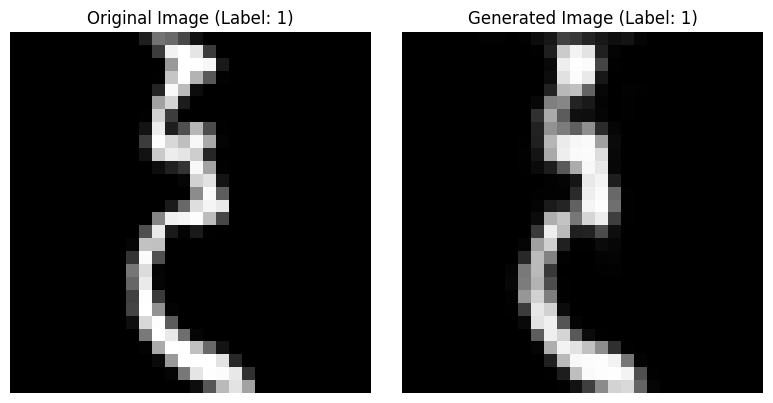

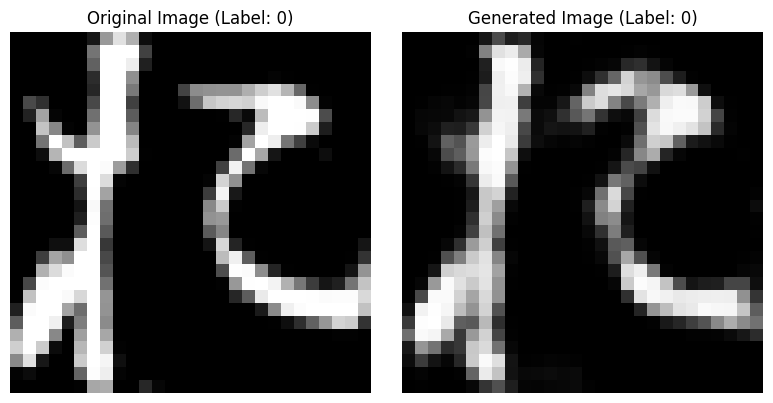

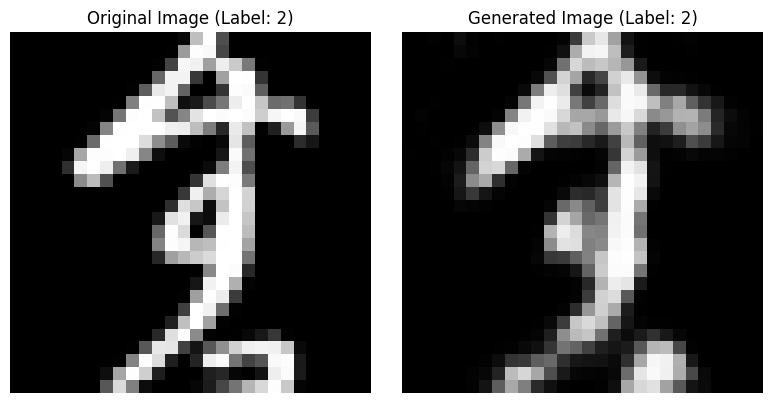

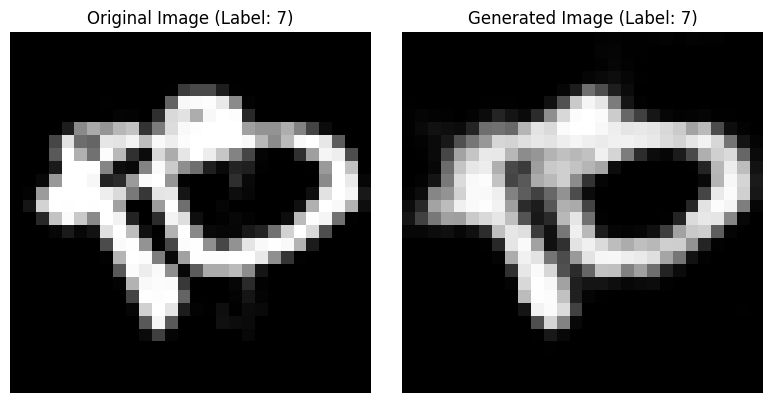

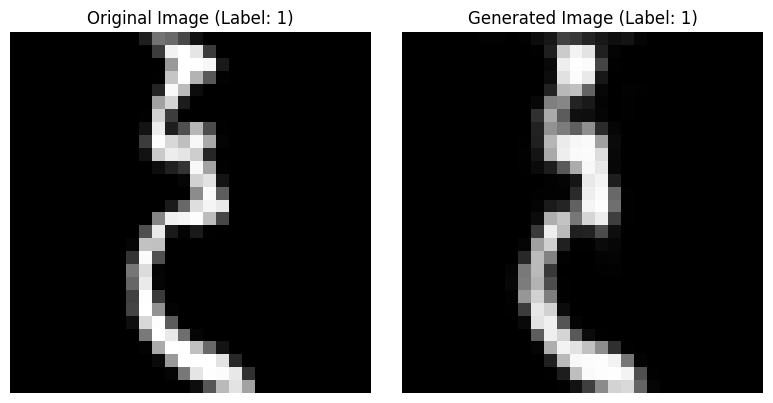

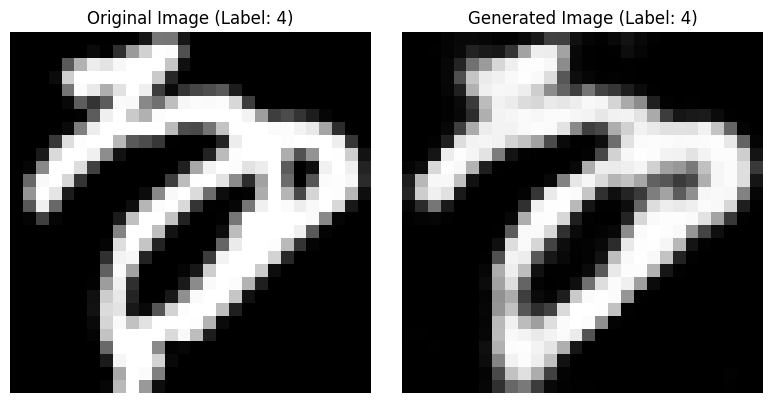

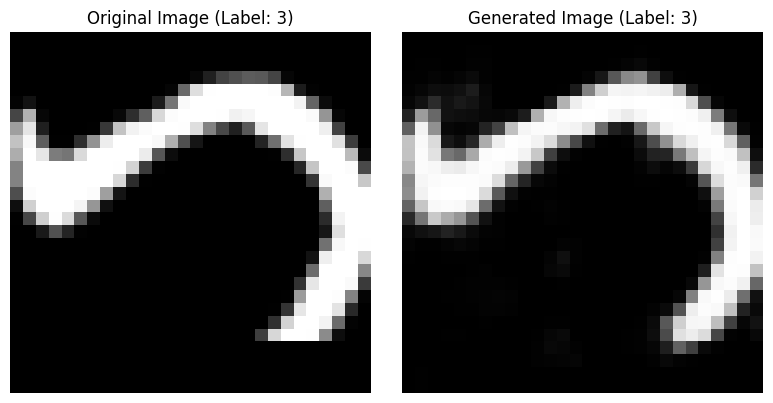

In [ ]:
# Generate bottleneck codes and their corresponding labels
num_images = 10  # Number of images to generate
bottleneck_size = autoencoder.get_layer('bottleneck').units  # Automatically determine bottleneck size
labels = np.random.choice(np.unique(y_train), size=num_images)  # Randomly select labels
bottleneck_codes = []

# Generate representative bottleneck codes based on the labels
bottleneck_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('bottleneck').output)
for label in labels:
    # Select a representative sample from the training set for each label
    class_indices = np.where(y_train == label)[0]
    representative_code = bottleneck_model.predict(x_train[class_indices[:1]])[0]
    bottleneck_codes.append(representative_code)

bottleneck_codes = np.array(bottleneck_codes)

# Use the decoder to generate images
generated_images = decoder.predict(bottleneck_codes)

# Visualize the generated images, their corresponding labels, and the original pictures
for i in range(num_images):
    original_idx = np.where(y_train == labels[i])[0][0]  # Find the original index
    original_image = x_train[original_idx].reshape(28, 28)  # Reshape original image

    # Plot side-by-side comparison
    plt.figure(figsize=(8, 4))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title(f"Original Image (Label: {labels[i]})")
    plt.axis('off')

    # Generated image
    plt.subplot(1, 2, 2)
    plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"Generated Image (Label: {labels[i]})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()



In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Extract representative codes for each class
def extract_representative_codes(autoencoder, x_train, y_train):
    """
    Extract one representative bottleneck code for each class.
    """
    bottleneck_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('bottleneck').output)
    representative_codes = []
    for class_label in np.unique(y_train):
        class_indices = np.where(y_train == class_label)[0]
        # Take the first sample from each class
        representative_code = bottleneck_model.predict(x_train[class_indices[:1]])[0]
        representative_codes.append(representative_code)
    return np.array(representative_codes)

# Step 2: Add Gaussian noise to bottleneck codes
def generate_noisy_images(decoder, representative_codes, num_images=1000, noise_variances=[0.1, 0.5, 1.0]):
    """
    Generate images by adding Gaussian noise to the bottleneck codes.
    """
    num_classes = len(representative_codes)
    images_per_class = num_images // num_classes
    augmented_images = []
    augmented_labels = []

    for variance in noise_variances:
        for class_idx, code in enumerate(representative_codes):
            for _ in range(images_per_class // len(noise_variances)):
                noisy_code = code + np.random.normal(0, variance, size=code.shape)
                generated_image = decoder.predict(np.expand_dims(noisy_code, axis=0))[0]
                augmented_images.append(generated_image)
                augmented_labels.append(class_idx)

    return np.array(augmented_images), np.array(augmented_labels)

# Step 3: Generate and visualize images
# Extract the trained decoder
decoder = extract_decoder(autoencoder)

# Extract representative codes for each class
representative_codes = extract_representative_codes(autoencoder, x_train, y_train)

# Generate 1,000 noisy images
noise_variances = [0.1, 0.5, 1.0]
augmented_images, augmented_labels = generate_noisy_images(decoder, representative_codes, num_images=1000, noise_variances=noise_variances)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━

1531/1531 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Test Accuracy After Augmenting Training Set: 0.9137
Training Time (Augmented Training Set): 48.92 seconds


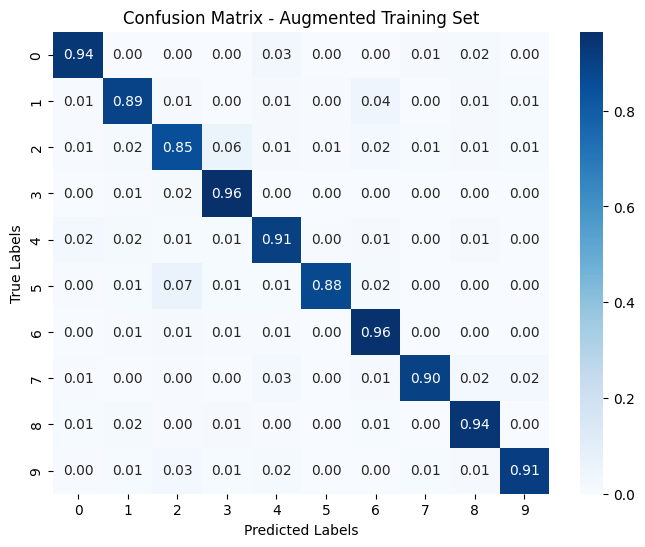

In [ ]:
# Combine original and newly generated data
combined_train_images = np.vstack([x_train, augmented_images])  # Combine original and generated images
combined_train_labels = np.hstack([y_train, augmented_labels])  # Combine corresponding labels

# Step 3: Extract Bottleneck Features for Combined Dataset
combined_features = extract_features(autoencoder, combined_train_images)
combined_features_scaled = scaler.fit_transform(combined_features)  # Scale the combined dataset features

# Step 4: Retrain the SVM Classifier on Combined Dataset
start_time = time.time()
svm_classifier.fit(combined_features_scaled, combined_train_labels)
training_time_augmented = time.time() - start_time

# Step 5: Evaluate on the Original Test Set
retrained_test_predictions = svm_classifier.predict(test_features_scaled)
retrained_test_accuracy = accuracy_score(y_test, retrained_test_predictions)

print(f"Test Accuracy After Augmenting Training Set: {retrained_test_accuracy:.4f}")
print(f"Training Time (Augmented Training Set): {training_time_augmented:.2f} seconds")

# Step 6: Plot Confusion Matrix
plot_confusion_matrix(y_test, retrained_test_predictions, title="Confusion Matrix - Augmented Training Set")

In [ ]:
test_labels_one_hot

<tf.Tensor: shape=(10000, 10), dtype=float32, numpy=
array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)>

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6416 - loss: 1.0711 - val_accuracy: 0.7661 - val_loss: 0.7506
Epoch 2/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9035 - loss: 0.3097 - val_accuracy: 0.8113 - val_loss: 0.6422
Epoch 3/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9384 - loss: 0.2026 - val_accuracy: 0.8314 - val_loss: 0.6037
Epoch 4/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9580 - loss: 0.1419 - val_accuracy: 0.8596 - val_loss: 0.5285
Epoch 5/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9707 - loss: 0.0998 - val_accuracy: 0.8805 - val_loss: 0.4753
Epoch 6/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9785 - loss: 0.0714 - val_accuracy: 0.8854 - val_loss: 0.4912
Epoch 7/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9825 - loss: 0.0547 - val_accuracy: 0.8802 - val_loss: 0.5525
Epoch 8/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9860 - loss: 0.0434 - val_accu

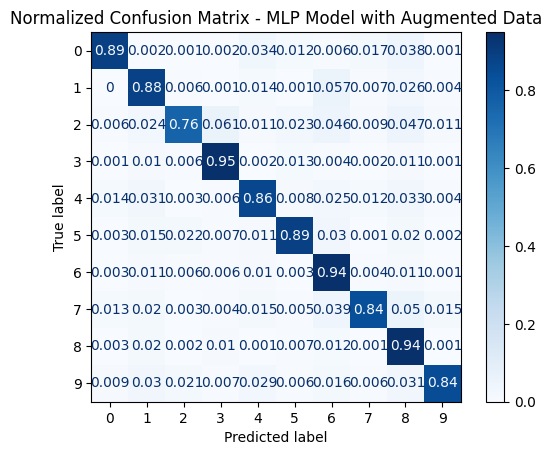

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt




x_test_processed = test_images.reshape(test_images.shape[0], -1) / 255.0  # Process test data similarly

# One-hot encode the labels
y_train_augmented_one_hot = tf.one_hot(combined_train_labels, depth=10)
test_labels_one_hot = tf.one_hot(test_labels, depth=10)

# Define the MLP model
num_layers = 3
num_units = 512
learning_rate = 0.001
patience = 10

time_augmented_MLP = time.time()

model = Sequential([Flatten(input_shape=(28 * 28,))])  # Input shape matches the flattened image dimensions
for _ in range(num_layers):
    model.add(Dense(num_units, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))  # Output layer for 10 classes

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# Train the MLP with augmented data
history = model.fit(combined_train_images, y_train_augmented_one_hot, epochs=100,
                    validation_data=(x_test, test_labels_one_hot),
                    batch_size=64, callbacks=[early_stopping], verbose=1)


# Evaluate the model
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = test_labels  # Keep test labels as integers for confusion matrix

# Calculate accuracy
test_accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate normalized confusion matrix
cm = confusion_matrix(y_true, y_pred_classes, normalize='true')

# Display the normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix - MLP Model with Augmented Data")
plt.show()



Training SAE with bottleneck size 16
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


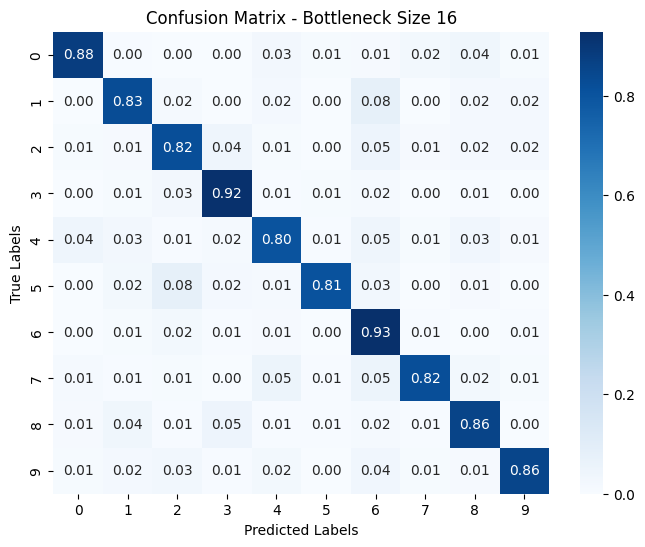

Bottleneck size 16 - Test Accuracy: 0.8529
Training SAE with bottleneck size 32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


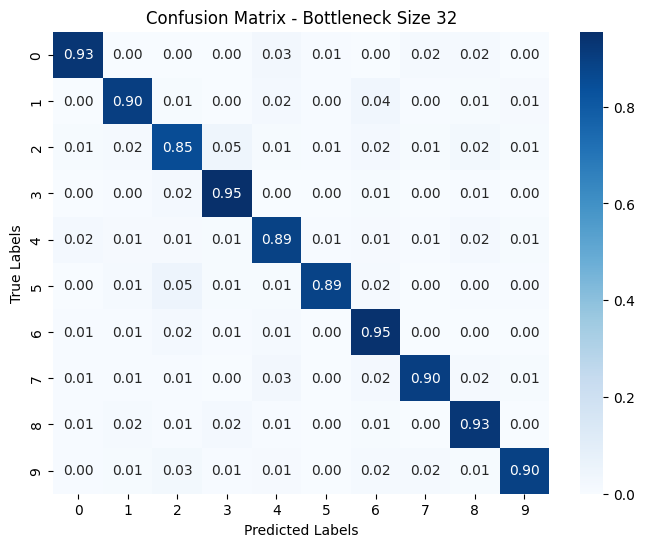

Bottleneck size 32 - Test Accuracy: 0.9080
Training SAE with bottleneck size 64
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


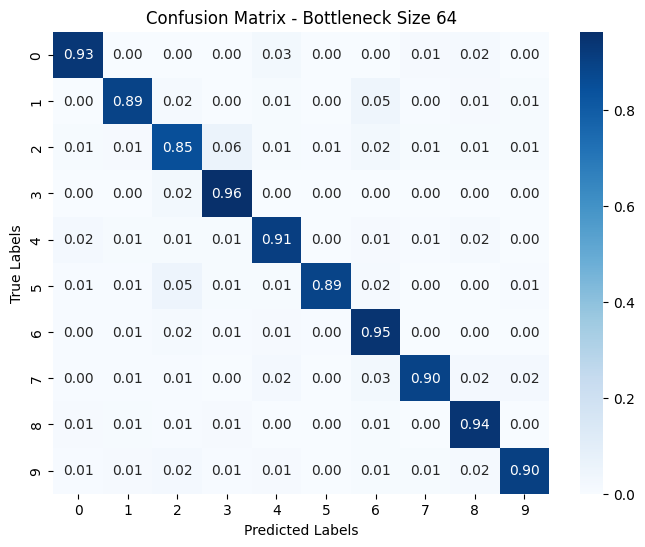

Bottleneck size 64 - Test Accuracy: 0.9131
Training SAE with bottleneck size 128
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


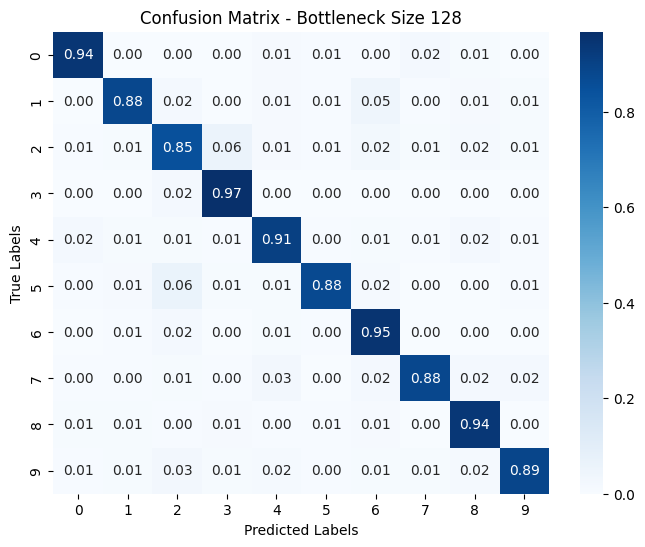

Bottleneck size 128 - Test Accuracy: 0.9096
Training SAE with bottleneck size 256
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


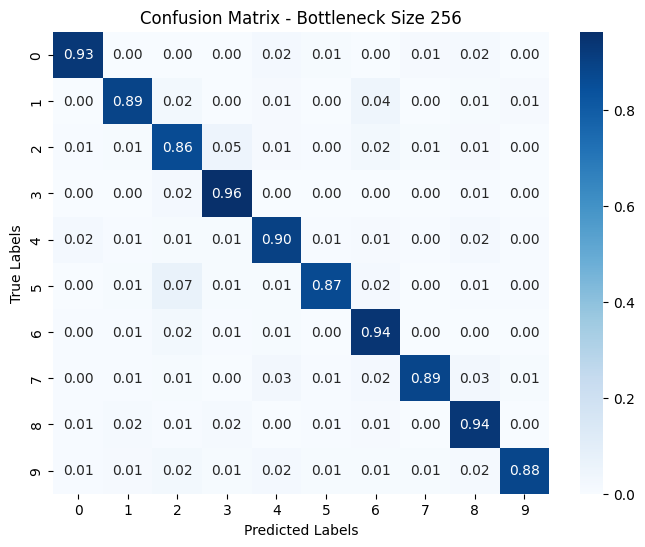

Bottleneck size 256 - Test Accuracy: 0.9059
Training SAE with bottleneck size 400
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


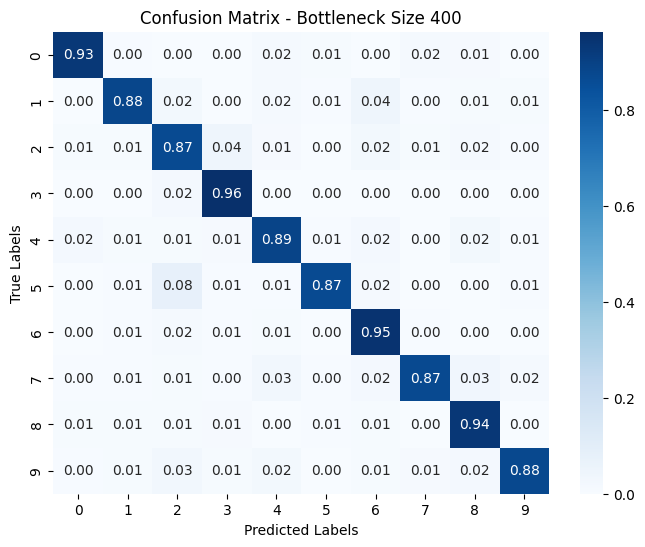

Bottleneck size 400 - Test Accuracy: 0.9037


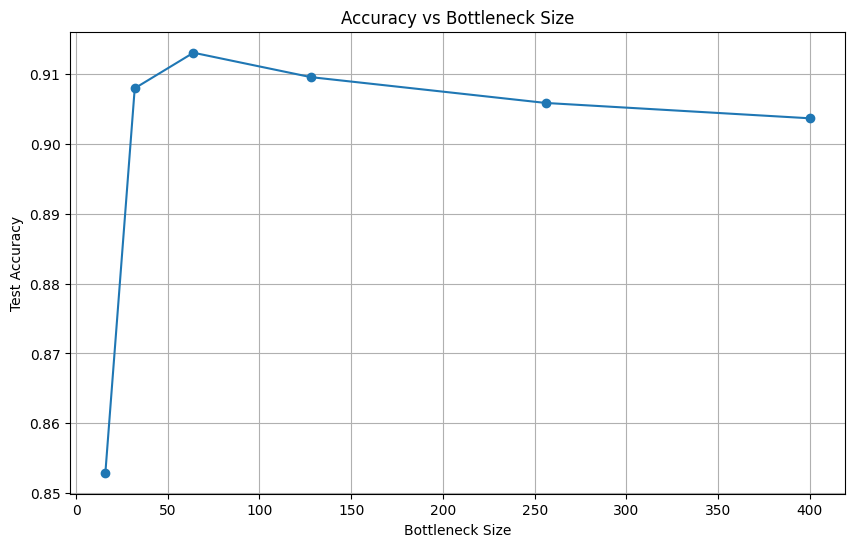

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import numpy as np


def plot_confusion_matrix(y_true, y_pred, title):
    """Plot a normalized confusion matrix."""
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Define bottleneck sizes to evaluate
bottleneck_sizes = [16, 32, 64, 128, 256, 400]
accuracies = []

for size in bottleneck_sizes:
    print(f"Training SAE with bottleneck size {size}")

    # Train the SAE with current bottleneck size
    autoencoder = build_sae(size)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(x_train, x_train, epochs=50, batch_size=64, validation_data=(x_val, x_val), verbose=0)

    # Extract features from the bottleneck layer
    train_features = extract_features(autoencoder, x_train)
    test_features = extract_features(autoencoder, x_test)

    # Scale features
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)
    test_features_scaled = scaler.transform(test_features)

    # Train the SVM on the extracted features
    svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale')
    svm_classifier.fit(train_features_scaled, y_train)

    # Predict on the test set
    test_predictions = svm_classifier.predict(test_features_scaled)
    accuracy = accuracy_score(y_test, test_predictions)
    accuracies.append(accuracy)

    # Plot the confusion matrix for the current bottleneck size
    plot_confusion_matrix(y_test, test_predictions, f"Confusion Matrix - Bottleneck Size {size}")
    print(f"Bottleneck size {size} - Test Accuracy: {accuracy:.4f}")

# Plot the bottleneck size vs accuracy
plt.figure(figsize=(10, 6))
plt.plot(bottleneck_sizes, accuracies, marker='o')
plt.title("Accuracy vs Bottleneck Size")
plt.xlabel("Bottleneck Size")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()


## Part 2

In [ ]:

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Flatten images for input into the SAE
x_train = train_images.reshape(-1, 784)
x_test = test_images.reshape(-1, 784)

# Split into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, train_labels, test_size=0.2, random_state=42)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(test_labels, num_classes=10)


In [ ]:
num_classes = 10
bottleneck_dim = 10  # Bottleneck size

np.random.seed(42)
targets = np.random.randn(num_classes, bottleneck_dim)
targets = targets / np.linalg.norm(targets, axis=1, keepdims=True)
targets_tensor = tf.convert_to_tensor(targets, dtype=tf.float32)


In [ ]:
targets_tensor

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[ 0.19172212, -0.05336737,  0.24999535,  0.5878603 , -0.09037871,
        -0.09037237,  0.6095458 ,  0.2962151 , -0.1812081 ,  0.20941776],
       [-0.13733657, -0.13802177,  0.07170694, -0.5670119 , -0.5111896 ,
        -0.16663723, -0.30015847,  0.09312905, -0.26909828, -0.41854453],
       [ 0.5769192 , -0.0888717 ,  0.02658094, -0.5608196 , -0.21428385,
         0.04366215, -0.4530624 ,  0.14788496, -0.23642772, -0.1148186 ],
       [-0.16840775,  0.5184221 , -0.00377765, -0.29603583,  0.23021674,
        -0.341694  ,  0.05845748, -0.5484793 , -0.37173736,  0.05509821],
       [ 0.26208815,  0.06082008, -0.04104457, -0.1068643 , -0.52474016,
        -0.25547892, -0.16348466,  0.3751818 ,  0.12195309, -0.6257181 ],
       [ 0.1467472 , -0.1743676 , -0.3065144 ,  0.27697077,  0.4668429 ,
         0.42168933, -0.38000283, -0.14001325,  0.1499981 ,  0.4417328 ],
       [-0.18139906, -0.07028417, -0.41882077, -0.4528431 ,  0.30759

In [ ]:
from tensorflow.keras.layers import Input, Dense, Layer

class PenaltyLayer(Layer):
    def __init__(self, targets, lambda_penalty, **kwargs):
        super(PenaltyLayer, self).__init__(**kwargs)
        self.targets = targets
        self.lambda_penalty = lambda_penalty

    def call(self, bottleneck_outputs, labels):
        # Map labels to target vectors
        targets_batch = tf.gather(self.targets, tf.argmax(labels, axis=1))

        # Compute penalty R
        squared_diff = tf.square(bottleneck_outputs - targets_batch)
        distances = tf.reduce_sum(squared_diff, axis=1)
        penalty_R = tf.reduce_mean(distances)

        # Add penalty to the model's total loss
        self.add_loss(self.lambda_penalty * penalty_R)
        return bottleneck_outputs


# Define SAE architecture
input_dim = 784  # Flattened input size
input_layer = Input(shape=(input_dim,))
encoder = Dense(800, activation='relu')(input_layer)
encoder = Dense(200, activation='relu')(encoder)
bottleneck = Dense(bottleneck_dim, activation='linear', name='bottleneck')(encoder)

# Add Penalty Layer
labels_input = Input(shape=(num_classes,), name='labels')  # One-hot labels as input
penalty_layer = PenaltyLayer(targets_tensor, lambda_penalty=0.1)(bottleneck, labels_input)

# Decoder
decoder = Dense(200, activation='relu')(penalty_layer)
decoder = Dense(800, activation='relu')(decoder)
output_layer = Dense(input_dim, activation='sigmoid')(decoder)

# Create the full model
autoencoder = Model(inputs=[input_layer, labels_input], outputs=output_layer)



In [ ]:

# Extract bottleneck model
bottleneck_model = Model(inputs=autoencoder.input[0], outputs=autoencoder.get_layer('bottleneck').output)

def evaluate_R(x_data, y_data):
    bottleneck_outputs = bottleneck_model.predict(x_data)
    y_labels = np.argmax(y_data, axis=1)  # Convert one-hot to class labels
    targets_batch = tf.gather(targets_tensor, y_labels)
    squared_diff = tf.square(bottleneck_outputs - targets_batch)
    distances = tf.reduce_sum(squared_diff, axis=1)
    penalty_R = tf.reduce_mean(distances)
    return penalty_R.numpy()

# Evaluate R on training set
penalty_R_train = evaluate_R(x_train, y_train)
print(f"Penalty R on training set: {penalty_R_train:.4f}")






1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Penalty R on training set: 1.8697


In [ ]:
# Compile and train the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model
history = autoencoder.fit(
    [x_train, y_train], x_train,
    validation_data=([x_val, y_val], x_val),
    epochs=30,
    batch_size=64,
    verbose=0
)

# Evaluate R after training
penalty_R_after = evaluate_R(x_train, y_train)
print(f"Penalty R after training: {penalty_R_after:.4f}")


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Penalty R after training: 0.0299


In [ ]:
# Train SAE with custom targets
autoencoder_custom = Model(inputs=[input_layer, labels_input], outputs=output_layer)
autoencoder_custom.compile(optimizer='adam', loss='mse')
autoencoder_custom.fit([x_train, y_train], x_train, epochs=20, batch_size=64)

# Extract bottleneck outputs
latent_train_custom = bottleneck_model.predict(x_train)
latent_test_custom = bottleneck_model.predict(x_test)


Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0453
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0445
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0443
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0441
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0441
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0442
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0442
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0438
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0434
Epoch 10/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0433
Epoch 11/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0431
Epoch 12/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0431
Epoch 13/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0430
Epoch 14/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0430
Epoch 15/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

In [ ]:
# Train SAE with direct assignments
direct_targets_tensor = tf.convert_to_tensor(np.eye(num_classes), dtype=tf.float32)
penalty_layer_direct = PenaltyLayer(direct_targets_tensor, lambda_penalty=0.1)(bottleneck, labels_input)

decoder = Dense(200, activation='relu')(penalty_layer_direct)
decoder = Dense(800, activation='relu')(decoder)
output_layer = Dense(input_dim, activation='sigmoid')(decoder)

autoencoder_direct = Model(inputs=[input_layer, labels_input], outputs=output_layer)
autoencoder_direct.compile(optimizer='adam', loss='mse')
autoencoder_direct.fit([x_train, y_train], x_train, epochs=20, batch_size=64)

# Extract bottleneck outputs
latent_train_direct = bottleneck_model.predict(x_train)
latent_test_direct = bottleneck_model.predict(x_test)


Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1012
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0685
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0607
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0567
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0544
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0527
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0514
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0504
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0497
Epoch 10/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0490
Epoch 11/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0482
Epoch 12/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0478
Epoch 13/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0473
Epoch 14/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0469
Epoch 15/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lo

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Custom targets
svm_custom = SVC(kernel='linear', C=1.0)
svm_custom.fit(latent_train_custom, np.argmax(y_train, axis=1))
train_acc_custom = svm_custom.score(latent_train_custom, np.argmax(y_train, axis=1))
test_acc_custom = svm_custom.score(latent_test_custom, np.argmax(y_test, axis=1))

print(f"SVM Accuracy (Custom Targets - Train): {train_acc_custom:.4f}")
print(f"SVM Accuracy (Custom Targets - Test): {test_acc_custom:.4f}")

# Direct assignments
svm_direct = SVC(kernel='linear', C=1.0)
svm_direct.fit(latent_train_direct, np.argmax(y_train, axis=1))
train_acc_direct = svm_direct.score(latent_train_direct, np.argmax(y_train, axis=1))
test_acc_direct = svm_direct.score(latent_test_direct, np.argmax(y_test, axis=1))

print(f"SVM Accuracy (Direct Assignments - Train): {train_acc_direct:.4f}")
print(f"SVM Accuracy (Direct Assignments - Test): {test_acc_direct:.4f}")


SVM Accuracy (Custom Targets - Train): 0.9980
SVM Accuracy (Custom Targets - Test): 0.8958
SVM Accuracy (Direct Assignments - Train): 0.9984
SVM Accuracy (Direct Assignments - Test): 0.8999


In [ ]:
def generate_target_sets(num_classes, bottleneck_dim, num_sets):
    target_sets = []
    for _ in range(num_sets):
        targets = np.random.randn(num_classes, bottleneck_dim)
        targets = targets / np.linalg.norm(targets, axis=1, keepdims=True)
        target_sets.append(tf.convert_to_tensor(targets, dtype=tf.float32))
    return target_sets

# Generate 5 different target sets
num_target_sets = 3
target_sets = generate_target_sets(num_classes=10, bottleneck_dim=10, num_sets=num_target_sets)


In [ ]:
# Define lambda values
lambda_values = [0.001, 0.01, 0.1, 0.2, 0.4, 0.8]

# Results storage
results_3d = []

for target_index, targets_tensor in enumerate(target_sets):
    for lambda_penalty in lambda_values:
        print(f"\nTraining with Target Set {target_index + 1}, Lambda={lambda_penalty}...")

        # Rebuild SAE with the current target set and lambda
        penalty_layer = PenaltyLayer(targets_tensor, lambda_penalty=lambda_penalty)(bottleneck, labels_input)
        decoder = Dense(200, activation='relu')(penalty_layer)
        decoder = Dense(800, activation='relu')(decoder)
        output_layer = Dense(input_dim, activation='sigmoid')(decoder)
        autoencoder = Model(inputs=[input_layer, labels_input], outputs=output_layer)
        autoencoder.compile(optimizer='adam', loss='mse')

        # Train SAE
        autoencoder.fit([x_train, y_train], x_train, epochs=25, batch_size=64, verbose=0,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

        # Evaluate penalty R on validation set
        penalty_R = evaluate_R(x_val, y_val)

        # Evaluate SVM accuracy on validation set
        latent_val = bottleneck_model.predict(x_val)
        svm = SVC(kernel='linear', C=1.0)
        svm.fit(latent_val, np.argmax(y_val, axis=1))
        val_acc = svm.score(latent_val, np.argmax(y_val, axis=1))

        # Store results
        results_3d.append({'target_set': target_index + 1, 'lambda': lambda_penalty,
                           'penalty_R': penalty_R, 'accuracy': val_acc})
        print(f"Penalty R: {penalty_R:.4f}, Accuracy: {val_acc:.4f}")




Training with Target Set 1, Lambda=0.001...


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Penalty R: 0.8818, Accuracy: 0.8502

Training with Target Set 1, Lambda=0.01...


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Penalty R: 0.2693, Accuracy: 0.9232

Training with Target Set 1, Lambda=0.1...


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Penalty R: 0.1191, Accuracy: 0.9552

Training with Target Set 1, Lambda=0.2...


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Penalty R: 0.1140, Accuracy: 0.9537

Training with Target Set 1, Lambda=0.4...


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Penalty R: 0.1149, Accuracy: 0.9524

Training with Target Set 1, Lambda=0.8...


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Penalty R: 0.1131, Accuracy: 0.9529

Training with Target Set 2, Lambda=0.001...


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Penalty R: 0.8589, Accuracy: 0.8411

Training with Target Set 2, Lambda=0.01...


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Penalty R: 0.2688, Accuracy: 0.9131

Training with Target Set 2, Lambda=0.1...


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Penalty R: 0.1303, Accuracy: 0.9436

Training with Target Set 2, Lambda=0.2...


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Penalty R: 0.1244, Accuracy: 0.9445

Training with Target Set 2, Lambda=0.4...


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Penalty R: 0.1256, Accuracy: 0.9414

Training with Target Set 2, Lambda=0.8...


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Penalty R: 0.1314, Accuracy: 0.9394

Training with Target Set 3, Lambda=0.001...


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Penalty R: 0.9119, Accuracy: 0.8306

Training with Target Set 3, Lambda=0.01...


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Penalty R: 0.2852, Accuracy: 0.9274

Training with Target Set 3, Lambda=0.1...


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Penalty R: 0.1648, Accuracy: 0.9404

Training with Target Set 3, Lambda=0.2...


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Penalty R: 0.1730, Accuracy: 0.9317

Training with Target Set 3, Lambda=0.4...


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Penalty R: 0.1830, Accuracy: 0.9247

Training with Target Set 3, Lambda=0.8...


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Penalty R: 0.1828, Accuracy: 0.9216


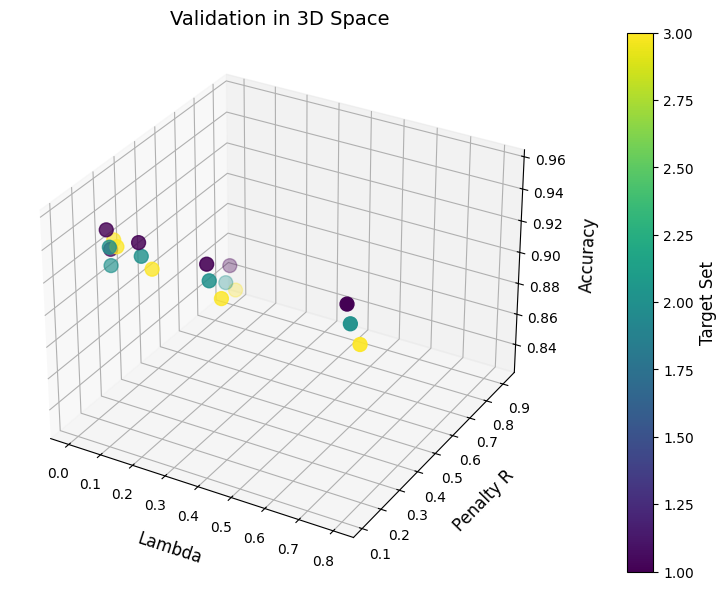

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D


results_df = pd.DataFrame(results_3d)

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    results_df['lambda'], results_df['penalty_R'], results_df['accuracy'],
    c=results_df['target_set'], cmap='viridis', s=100
)

# Add a color bar for target sets
cbar = plt.colorbar(scatter, pad=0.1)
cbar.set_label('Target Set', fontsize=12)

# Set labels and title
ax.set_xlabel('Lambda', labelpad=10, fontsize=12)
ax.set_ylabel('Penalty R', labelpad=10, fontsize=12)
ax.set_zlabel('Accuracy', labelpad=10, fontsize=12)
ax.set_title('Validation in 3D Space', fontsize=14)

# Adjust tick label sizes
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='z', labelsize=10)

# Add a grid for better reference
ax.grid(True)

# Show the plot
plt.show()


